Code Sample Submission For Quilter\
Cristian Mendoza, 12/28/21

For this sample, I decided to implement from scratch a prototype version of Facebook's DETR (DEtection TRansformer) network for object detection. One of the contstraints I am working with is that I only have a single GPU that's seen better days. With this in mind, I replace all of DETR's self-attention mechanisms with Fast Fourier Transforms as described in Google's FNet paper. I haved dubbed this new network FDETR. The .py files in this repo contain the implementation.

The dataset I work with in this notebook is Defect Detection in PCB boards, taken from Kaggle.

DETR Paper:
https://arxiv.org/pdf/2005.12872.pdf

FNET Paper:
https://arxiv.org/pdf/2105.03824.pdf

PCB Defect Detection Dataset:
https://www.kaggle.com/sudharshann/pcb-defect-dataset

In [1]:
#imports
from FDETRDataGen import *
from FDETR import *
from HungarianMatcher import *
from backbone import *
from Transformer import *

import pandas as pd #to read in truth
from collections import Counter
import matplotlib.pyplot as plt #for viz
import cv2 as cv #for viz
import time #to time epochs

In [2]:
#dataset metadata
input_shape = (600, 600, 3)
num_classes = 6

#hyperparams
d_model = 512 #latent dimension for transformer
batch_size = 4 #I only have one (very old) gpu!!!
learning_rate = 1e-4 
weight_decay = 1e-4
N_obj = 50 #num of queries for transformer decoder
epochs = 12

In [3]:
#Truth data was compiled from PASCAL VOC formatted labels into csvs
train_path = 'D:\\quilter\\archive_v3\\VOC_PCB\\Annotations\\train\\train_annotations_redux.csv'
val_path = 'D:\\quilter\\archive_v3\\VOC_PCB\\Annotations\\val\\val_annotations_redux.csv'
test_path = 'D:\\quilter\\archive_v3\\VOC_PCB\\Annotations\\test\\test_annotations_redux.csv'

#read in the data
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

#set up data generators
train_datagen = FDETRDataGen(train_df, N_obj=N_obj, batch_size=batch_size, input_shape=input_shape)
val_datagen = FDETRDataGen(val_df, N_obj=N_obj, batch_size=batch_size, input_shape=input_shape)
test_datagen = FDETRDataGen(test_df, N_obj=N_obj, batch_size=batch_size, input_shape=input_shape)

Let's look into this data a bit.

In [4]:
train_num_images = len(train_df['filename'].unique())
train_num_samples = len(train_df)
val_num_images = len(val_df['filename'].unique())
val_num_samples = len(val_df)
test_num_images = len(test_df['filename'].unique())
test_num_samples = len(test_df)

print(f'There are {train_num_images} images in the training set.')
print(f'There are {train_num_samples} annotated objects in the training set.')

print(f'There are {val_num_images} images in the validation set.')
print(f'There are {val_num_samples} annotated objects in the validation set.')

print(f'There are {test_num_images} images in the test set.')
print(f'There are {test_num_samples} annotated objects in the test set.')

classes = train_df['class'].unique()
print(f'classes: {classes}')

There are 8640 images in the training set.
There are 17524 annotated objects in the training set.
There are 961 images in the validation set.
There are 1976 annotated objects in the validation set.
There are 1067 images in the test set.
There are 2164 annotated objects in the test set.
classes: ['missing_hole' 'mouse_bite' 'open_circuit' 'short' 'spurious_copper'
 'spur']


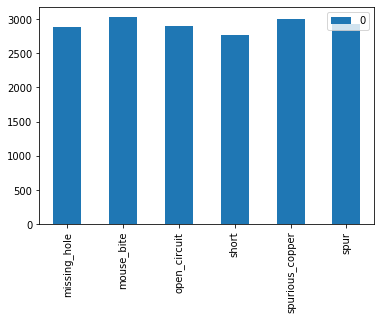

In [5]:
#look at class distribution in the training set
class_df = train_df['class']

class_counts = Counter(class_df)

class_count_df = pd.DataFrame.from_dict(class_counts, orient='index')

class_count_df.plot(kind='bar')

Looks like the dataset is fairly class-balanced. Let's visualize some of the images and annotations.

In [6]:
#randomly sample one image from each class (each image only has one type of defect in it)
viz_files = []
for label in classes:
    viz_files.append(train_df[train_df['class']==label].sample(n=1)['filename'].iloc[0])

In [7]:
def display_one_sample(img, title, subplt):
    plt.subplot(subplt)
    plt.axis('off')
    plt.imshow(img)
    plt.title(title, fontsize=16)

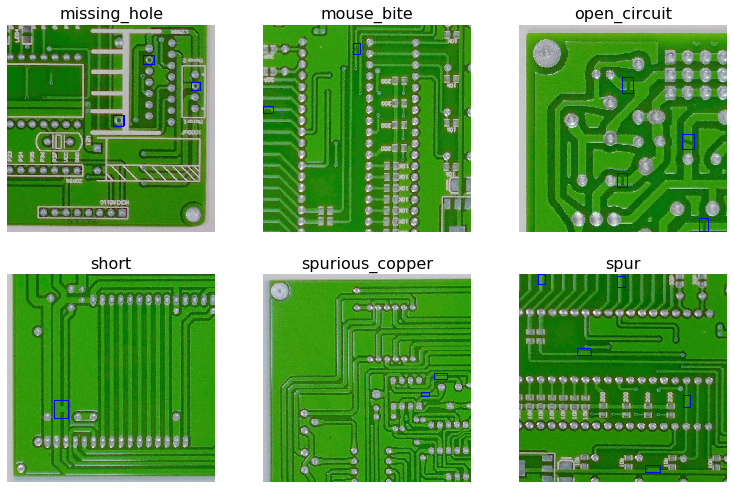

In [8]:
subplt = 331
plt.figure(figsize=(13, 13))
for i in range(len(viz_files)):
    img = cv.imread(viz_files[i])
    truth = train_df[train_df['filename']==viz_files[i]]
    label = truth['class'].iloc[0]
    
    for obj in range(len(truth)):
        #draw rectangles on the images
        xmin = int(truth.iloc[obj]['xmin'])
        ymin = int(truth.iloc[obj]['ymin'])
        xmax = int(truth.iloc[obj]['xmax'])
        ymax = int(truth.iloc[obj]['ymax'])

        color = (0, 0, 255) #blue
        cv.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

    display_one_sample(img, label, subplt+i)

The annotated objects are small compared to the size of the images. The DETR paper mentions that their architecture struggles when detecting small objects. To address this, I could chip the images down into smaller images. I will save that work for another day. For now, let's move on to setting up the model.

In [9]:
#set up model. FDETR uses a ResNet50 backbone to get the image features and a Transformer with Fourier Self-Attention

#this optimizer is the Weighted Adam optimizer that applies l2 regularization after every epoch
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
#the matcher performs bipartate matching between predicted boxes and true boxes. This mechanism replaces anchors.
matcher = HungarianMatcher()
#this is the custom loss function defined in the DETR paper
loss_fcn = FDETR_Loss(num_classes, matcher)

fdetr = FDETR(cnn_backbone(d_model, batch_size, input_shape), Transformer(batch_size, d_model=d_model), num_classes, N_obj, d_model=d_model)

In [10]:
#build the model by feeding a random sample through it
arb_in = tf.random.uniform((batch_size, input_shape[0], input_shape[1], input_shape[2]))
rndm_task = fdetr(arb_in)

In [11]:
fdetr.summary()

Model: "fdetr"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          [(None, 38, 38, 512),     1722752   
                              (4, 38, 38, 512)]                  
                                                                 
 transformer (Transformer)   multiple                  16811018  
                                                                 
Total params: 18,559,374
Trainable params: 18,539,008
Non-trainable params: 20,366
_________________________________________________________________


This is a relatively small model for the task I am training it to do. This is done mostly for demonstration reasons, but also because I have limited compute on my home computer. I expect this model to be underparameterized.

In [12]:
#set up classification and regression metrics for the training loop
train_clf_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_clf_metric = tf.keras.metrics.SparseCategoricalAccuracy()

train_box_metric = tf.keras.metrics.MeanAbsoluteError()
val_box_metric = tf.keras.metrics.MeanAbsoluteError()

Next, I implement a custom training loop. Being that this is a rough implementation from PyTorch to Tensorflow/Numpy, some of the background functions do not play nice with Keras' model.fit() API. To fix this, I would need only a day or two of work to migrate the background functions to a TF-Friendly version.

At the end of each epoch, I report on the FDETR loss. This is the sum of the categorical crossentropy of its class predictions with the L1-norm of the box predictions and the Generalized Intersection over Union (GIoU) loss. I also report the accuracy, the L1 error, and the GIoU loss for both training and validation sets.

In [13]:
train_loss, train_acc, train_err, train_giou = [], [], [], []
val_loss, val_acc, val_err, val_giou = [], [], [], []
for epoch in range(epochs):
    start_time = time.time()
    print(f'Epoch {epoch+1}/{epochs}...')

    epoch_loss = []
    epoch_giou = []
    #iterate over batches in dataset
    for step, _ in enumerate(train_datagen):
        X, y_true = train_datagen[step]
        with tf.GradientTape() as tape:
            
            y_pred = fdetr(X, training=True)

            loss = loss_fcn(y_true, y_pred)

        epoch_loss.append(loss)
        grads = tape.gradient(loss, fdetr.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, 0.1)
        optimizer.apply_gradients(zip(grads, fdetr.trainable_variables))

        indices = matcher.match(y_true, y_pred)

        src_boxes, tgt_boxes, src_logits, tgt_labels, num_total_boxes = get_src_tgt_pairs(y_true, y_pred, batch_size, indices)

        #update training metrics
        train_clf_metric.update_state(tgt_labels, src_logits)
        train_box_metric.update_state(tgt_boxes, src_boxes)
        giou_loss = tfa.losses.GIoULoss()(tgt_boxes, src_boxes).numpy()
        epoch_giou.append(giou_loss)

    #display training metrics
    train_clf = train_clf_metric.result()
    train_box = train_box_metric.result()
    print(f'loss: {epoch_loss[-1]} | classification accuracy: {float(train_clf)} | box error: {float(train_box)} | giou loss: {epoch_giou[-1]}')
    train_loss.append(epoch_loss[-1])
    train_acc.append(train_clf)
    train_err.append(train_box)
    train_giou.append(epoch_giou[-1])

    #reset training metrics
    train_clf_metric.reset_states()
    train_box_metric.reset_states()

    #run validation step
    val_epoch_loss = []
    val_epoch_giou = []
    for step, _ in enumerate(val_datagen):
        X, y_true = val_datagen[step]

        y_pred = fdetr(X, training=False)
        
        loss = loss_fcn(y_true, y_pred)

        val_epoch_loss.append(loss)

        indices = matcher.match(y_true, y_pred)

        batch_size = len(y_true)

        src_boxes, tgt_boxes, src_logits, tgt_labels, num_total_boxes = get_src_tgt_pairs(y_true, y_pred, batch_size, indices)

        val_clf_metric.update_state(tgt_labels, src_logits)
        val_box_metric.update_state(tgt_boxes, src_boxes)
        giou_loss = tfa.losses.GIoULoss()(tgt_boxes, src_boxes).numpy()
        val_epoch_giou.append(giou_loss)

    val_clf = val_clf_metric.result()
    val_box = val_box_metric.result()
    print(f'val loss: {val_epoch_loss[-1]} | val classification accuracy: {float(val_clf)} | val box error: {float(val_box)} | val giou loss: {val_epoch_giou[-1]}')
    val_acc.append(val_clf)
    val_err.append(val_box)
    val_loss.append(val_epoch_loss[-1])
    val_giou.append(val_epoch_giou[-1])

    val_clf_metric.reset_states()
    val_box_metric.reset_states()

    print(f'Time for epoch {epoch}: {time.time() - start_time}s')

Epoch 1/12...
loss: 1.3483645915985107 | classification accuracy: 0.8140835165977478 | box error: 0.2759142518043518 | giou loss: 1.399999976158142
val loss: 4.9180755615234375 | val classification accuracy: 0.7854251265525818 | val box error: 0.2759552001953125 | val giou loss: 1.0
Time for epoch 0: 1985.6774733066559s
Epoch 2/12...
loss: 1.3354723453521729 | classification accuracy: 0.8123995661735535 | box error: 0.27630186080932617 | giou loss: 1.4695549011230469
val loss: 5.263288497924805 | val classification accuracy: 0.7970647811889648 | val box error: 0.2769871652126312 | val giou loss: 1.0
Time for epoch 1: 1838.4619588851929s
Epoch 3/12...
loss: 1.5163929462432861 | classification accuracy: 0.8098737001419067 | box error: 0.2752566635608673 | giou loss: 1.6666666269302368
val loss: 4.785852909088135 | val classification accuracy: 0.8026315569877625 | val box error: 0.2750263214111328 | val giou loss: 1.0
Time for epoch 2: 1840.43377327919s
Epoch 4/12...
loss: 1.1774559020996

Huh. I did not expect the classification accuracy to be so high with so few epochs, much less right out of the gate. The box error and the giou loss are not so great, however. All of the metrics seem to be stuck. That's not good. I hypothesize that FDETR is getting stuck for one or a combination of the following reasons:

- The learning rate is too small/big: The optimizer could be stuck in a valley or overshooting valleys on the loss surface.
- The batch size is too small: Since we are only sending in 4 samples at a time, the normalization layers are seeing too much variance within the data between batches, and thus not learning much.
- The capacity of the model is too small: Many object detector networks have many tens of millions of parameters. This one is small so that it can fit on my gpu at home.  

Conclusion

It should be mentioned that transformers benefit from extra-long training schedules. As such, I expected FDETR to not learn much in a mere 12 epochs. That number was chosen so that I could present a sample of what I am capable of.

Coding this sample has been a fun exercise in research and experimentation. Given some more time, first priority would be to migrate all of the numpy background code to TF, so that the model could take advantage of tensorflow's graph compilation and speed up training times.

There are also some features described in the DETR paper I did not get around to implementing, those being adding so-called Hungarian Loss to regularize the output of the decoder layer. The other thing was feeding an attention mask to the cross-attention mechanism in the decoder. I suspect both of these would help guide training better.

Finally, I would want to write a testing function, so I can get a quantitative understanding of FDETR's performance.